In [1]:
import numpy as np
from jinja2 import Template
import glob, os
import matplotlib.pyplot as plt
from feos.si import *
import moleculegraph
from moleculegraph.funcs import read_pair_potentials, read_bond_potentials, read_angle_potentials, read_torsion_potentials

In [2]:
# Define Molecule


species = "1.2-Ethanediol"
print(species)
mol    = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alcohol][OH_alcohol][cH_alcohol]"
reftor = [1,2,3,4]


#species = "1.3-Propanediol"
#print(species)
#mol    = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH2_alcohol][OH_alcohol][cH_alcohol]"
#reftor = [1,2,3,4]
#reftor = []


#species = "1.4-Butanediol"
#print(species)
#mol    = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH2_alkane][CH2_alcohol][OH_alcohol][cH_alcohol]"
#reftor = [2,3,4,5]

    
# path to force-field
path = "force-fields/UA_devel/"    
    
molecule = moleculegraph.molecule(mol)

# If a torsion is twice in one molecule, then evaluate the mie interaction for every 1.4 pair in this molecule

reftor_name = [k for k,l in zip(molecule.torsion_keys,molecule.torsion_list) if list(l) == reftor ][0]
reftor_list = [[l[0],l[3]] for k,l in zip(molecule.torsion_keys,molecule.torsion_list) if reftor_name == k]

1.2-Ethanediol


In [3]:
from scipy.constants import epsilon_0,k,e

def calc_mie(r: np.ndarray, sigma: float, eps: float, n: int, m: int=6, key: str= "energy"):
    """
    This function computes the energy / force of the Mie potential for a given sigma, epsilon, distance, and repuslive, attrative exponent.

    Args:
        r (np.ndarray): Distance of the two atoms. Given in the same unit as sigma.
        sigma (float): Mixed sigma of the two atoms. Given in the same unit as the distance.
        eps (float): Mixed epsilon of the two atoms. Given in the energy unit.
        n (int): Repulsive exponent.
        m (int): Attractive exponent. Defaults to 6.
        key (str, optional): Key specifing if the energy (enery) or the force (force) should be computed. Defaults to "energy".

    Returns:
        mf (float): Either the energy or the force acting between the two atoms.
    """

    if eps > 0:

        # Mie constant
        c0 = n /  ( n - m ) * ( n / m )**( m / ( n - m ) )

        # energy U(r)
        if key == "energy":
            mf = c0 * eps * ( ( sigma / r ) ** n - ( sigma / r ) ** m) 
        
        # force = -dU(r)/dr
        if key == "force":
            mf = -c0 * eps * ( m / r * ( sigma / r )**m - n / r * ( sigma/ r )**n )
            
    else:
        mf = np.zeros(len(r))

    return mf

def calc_coulomb(r: np.ndarray | np.ndarray, q1: float, q2: float, key: str= "energy"):
    """
    This function computes the energy / force of the Coulomb potential for given distance, and partial charges of the two atoms.

    Args:
        r (np.ndarray): Distance of the two atoms. Given in the same unit as sigma.
        q1 (float): Partial charge of atom one. Given in portions of eletron charge.
        q2 (float): Partial charge of atom two. Given in portions of eletron charge.
        key (str, optional): Key specifing if the energy (enery) or the force (force) should be computed. Defaults to "energy".

    Returns:
        qf (float): Either the energy or the force acting between the two atoms.
    """
    
    if q1 != 0.0 and q2!= 0.0:
        
        konst = ( 1e10 * e**2 ) / ( 4 * np.pi * epsilon_0 * k )    

        # Energy U(r) = q1q2/r
        if key == "energy":
            qf    = q1 * q2 * konst / r 
        
        # Force = -dU(r)/dr = -d/dr (q1*q2*r^(-1)) = - (-q1*q2/r^2) = q1q2/r^2
        if key == "force":
            konst = ( 1e10 * e**2 ) / ( 4 * np.pi * epsilon_0 * k )  
            qf = q1 * q2 * konst / r**2
    else:
        qf = np.zeros(len(r))

    return qf

def calc_bond(r: np.ndarray, r0: float, K: float, key = "energy"):
    """
    This function computes the energy / force of the harmonic bond potential for given distance, spring constant and equilibrium length.

    Args:
        r (np.ndarray): Distance of the two atoms. Given in the same unit as sigma.
        r0 (float): Equilibrium length of the bond.
        K (float): Harmonic spring constant of the bond.
        key (str, optional): Key specifing if the energy (enery) or the force (force) should be computed. Defaults to "energy".

    Returns:
        bf (float): Either the energy or the force acting between the two atoms. 
    """
    # Energy U(r) = K * (r-r0)^2
    if key == "energy":
        bf = K * ( r - r0 )**2
    
    # Force -dU(r)/dr = -K * 2 * (r-r0)
    if key == "Force":
        bf = -K * 2 * ( r - r0 )
        
    return bf

In [4]:
# Read force-field

pair_pots    = read_pair_potentials(glob.glob(path+"/pair_potentials")[0])
bond_pots    = read_bond_potentials(glob.glob(path+"/bond_potentials")[0])
angle_pots   = read_angle_potentials(glob.glob(path+"/angle_potentials")[0])
torsion_pots = read_torsion_potentials(glob.glob(path+"/torsion_potentials")[0])

In [5]:
flag = 0
dipol_list = []

for i,(atom,no) in enumerate(zip(molecule.atom_names,molecule.atom_numbers)):
    
    if (pair_pots[atom]["charge"] != 0 and flag == 0):
        
        dipol = []
        chrg = 0
        chrg += pair_pots[atom]["charge"]
        flag = 1
        dipol.append((atom,no))
        
    elif(pair_pots[atom]["charge"] != 0 and flag == 1):
        
        #Check if next atom is bonded to the previous one
        
        atom_no1 = molecule.atom_numbers[i]
        atom_no2 = molecule.atom_numbers[i-1]
        distance = molecule.get_distance(atom_no1,atom_no2)

        if distance == 1.0:
            chrg += pair_pots[atom]["charge"]
            dipol.append((atom,no))
            
        #Check if the total charge is 0, then its a local dipol
        
            if np.round(chrg,3) == 0:
                dipol_list.append(dipol)
                flag = 0

                
print("Dipol list:\n")
for dipol in dipol_list:
    print(dipol)

Dipol list:

[('cH_alcohol', 0), ('OH_alcohol', 1), ('CH2_alcohol', 2)]
[('CH2_alcohol', 3), ('OH_alcohol', 4), ('cH_alcohol', 5)]


In [6]:
# Bestimmte auszuwertetende WW

mie           = []
coul          = []
special_names = []

#Durch zusätzlichen Bonds verkürzen sich die Bindungsabstände der dahinterliegenden WW
#Bsp durch die O-O "Bond" sind die cH_alcohole effektiv nur noch 3 Bindungen entfernt und werden nicht
#in LAMMPS ausgewertet, darum schreibe in Table

# Mie für alle WW (auch längere Abstände)

for x,a in enumerate(molecule.atom_numbers):
    for y,b in enumerate(molecule.atom_numbers[x+1:]):
        print(molecule.atom_names[a],molecule.atom_names[b],molecule.get_distance(a,b))
        if molecule.get_distance(a,b) > 3:
            print("check")
            mie.append([a,b])
        elif [a,b] in reftor_list:
            mie.append([a,b])

# Coul für alle WW innerhalb der Charge Groups

for i,a in enumerate(dipol_list):
    for j,b in enumerate(dipol_list[i:]):
        if b !=a:
            for aa in a:
                for bb in b:
                    coul.append([aa[1],bb[1]])

# Berücksichtige als erstes alle Mie WW, addiere dann alle zusätzlichen Coulomb WW dazu.
# Dies ist besonders für längere Moleküle wichtig (z.B Butandiol)

total_pair = mie.copy()

print("")
print("Special Mie interaction\n")
for a in mie:
    print(molecule.atom_names[a[0]],molecule.atom_names[a[1]])
    special_names.append([molecule.atom_names[a[0]],molecule.atom_names[a[1]]])
print("")
print("Special Coulomb interaction\n")
for a in coul:
    print(molecule.atom_names[a[0]],molecule.atom_names[a[1]])
    if not [molecule.atom_names[a[0]],molecule.atom_names[a[1]]] in special_names:
        special_names.append([molecule.atom_names[a[0]],molecule.atom_names[a[1]]])
        total_pair.append(a)

helper = []
for i,a in enumerate(special_names):
    for j,b in enumerate(special_names):
        b.reverse()
        if (a == b and i !=j):
            special_names[i] = b
            helper.append(i)

#Get the right dictkey for bonded WW            
special_key   = []
for i in special_names:
    if "["+"][".join(i)+"]" in list(molecule.bond_keys):
        special_key.append("["+"][".join(i)+"]")
    elif "["+"][".join(i[::-1])+"]"in list(molecule.bond_keys):
        special_key.append("["+"][".join(i[::-1])+"]")
        
#Just unique bond names WW
test,idx = np.unique(special_key,axis=0,return_index=True)
special_key = test[idx.argsort()]

#Just unique pair names and coul WW
#special_names = ["".join([w[0].split("_")[0],w[1].split("_")[0]]) for w in special_names]
#special_names = ["".join([w[0],w[1]]) for w in special_names]
special_names =  special_bond_keys = [ "[special]"+moleculegraph.make_graph(moleculegraph.sort_force_fields(x)) for x in special_names ]
total_pair = np.delete(np.array(total_pair),helper,axis=0).tolist()

#unique sort the array; undo the sort
test,idx = np.unique(special_names,axis=0,return_index=True)
special_names = test[idx.argsort()]

print("")
print("Table dict")
print(special_names)

print("")
print("Bonded dict")
print(special_key)

print("")
print("Total special interaction\n")
for a in total_pair:
    print(molecule.atom_names[a[0]],molecule.atom_names[a[1]])

cH_alcohol OH_alcohol 1.0
cH_alcohol CH2_alcohol 2.0
cH_alcohol CH2_alcohol 3.0
cH_alcohol OH_alcohol 4.0
check
cH_alcohol cH_alcohol 5.0
check
OH_alcohol CH2_alcohol 1.0
OH_alcohol CH2_alcohol 2.0
OH_alcohol OH_alcohol 3.0
OH_alcohol cH_alcohol 4.0
check
CH2_alcohol CH2_alcohol 1.0
CH2_alcohol OH_alcohol 2.0
CH2_alcohol cH_alcohol 3.0
CH2_alcohol OH_alcohol 1.0
CH2_alcohol cH_alcohol 2.0
OH_alcohol cH_alcohol 1.0

Special Mie interaction

cH_alcohol OH_alcohol
cH_alcohol cH_alcohol
OH_alcohol OH_alcohol
OH_alcohol cH_alcohol

Special Coulomb interaction

cH_alcohol CH2_alcohol
cH_alcohol OH_alcohol
cH_alcohol cH_alcohol
OH_alcohol CH2_alcohol
OH_alcohol OH_alcohol
OH_alcohol cH_alcohol
CH2_alcohol CH2_alcohol
CH2_alcohol OH_alcohol
CH2_alcohol cH_alcohol

Table dict
['[special][OH_alcohol][cH_alcohol]' '[special][cH_alcohol][cH_alcohol]'
 '[special][OH_alcohol][OH_alcohol]' '[special][CH2_alcohol][cH_alcohol]'
 '[special][CH2_alcohol][OH_alcohol]'
 '[special][CH2_alcohol][CH2_alcohol]

In [7]:
#Auswerten der Potentiale und Kräfte

KB_kcal = 1/ (CALORIE*KILO /MOL / NAV /KB /KELVIN) #Umrechnen von Kelvin in K_cal/mol (Kelvin * R == Joule/mol / 4.184 = cal/mol /1000 = kcal/mol)

energy_list = []
plot_dict   = {}

#N auswertungen (numerische Auswertung der Kräfte ist schwer, darum viele Stützstellen in Bereichen großer Gradienten)
N1 = 80000
N2 = 20000
N  = N1+N2

#Cutoff in Angström
cutoff = 14 

#Bestimme für Mie WW das entscheidende Sigma. Vor sigma viele Stützstellen danach wenige

sig = min([(pair_pots[molecule.atom_names[a[0]]]["sigma"] + pair_pots[molecule.atom_names[a[1]]]["sigma"])*0.5 for a in mie])

r1  = np.linspace(0.8*sig,1.1*sig,N1)
r2  = np.linspace(1.11*sig,cutoff,N2)

#Bestimme für restlichen Coul WW das entscheidende Sigma. Vor sigma viele Stützstellen danach wenige

sig = min([(pair_pots[molecule.atom_names[a[0]]]["sigma"] + pair_pots[molecule.atom_names[a[1]]]["sigma"])*0.5 for a in coul])

r3  = np.linspace(0.8*sig,1.1*sig,N1)
r4  = np.linspace(1.11*sig,cutoff,N2)

#Für Bonded Atoms benutzte kürzere range (bond_length wird eigentlich zu TAMie wert gezwungen)

leg_min  = min([[bond_pots[i]["p"][0] for i in special_key] if len(special_key) > 0 else 10][0])
leg_max  = max([[bond_pots[i]["p"][0] for i in special_key] if len(special_key) > 0 else 10][0])

r5   = np.linspace(0.98*leg_min,1.2*leg_max,N)

for q,w in enumerate(coul):
    #Calculate Mie / Coul / Bond Potential and Force (unit = Kelvin)
    
    dict_key = special_names[q]
    
    pot_bond   = 0
    pot_mie    = 0
    force_bond = 0
    force_mie  = 0
    
    if molecule.get_distance(w[0],w[1]) == 1:
        #Nutze bei Bindung andere Range
        r    = r5
        if "["+"][".join([molecule.atom_names[w[0]],molecule.atom_names[w[1]]])+"]" in special_key:
            name = "["+"][".join([molecule.atom_names[w[0]],molecule.atom_names[w[1]]])+"]"
        elif "["+"][".join([molecule.atom_names[w[1]],molecule.atom_names[w[0]]])+"]" in special_key:
            name = "["+"][".join([molecule.atom_names[w[1]],molecule.atom_names[w[0]]])+"]"
        else:
            print("No Bondkey")
            
        pot_bond   = calc_bond(r,bond_pots[name])
        force_bond = calc_bond(r,bond_pots[name],"Force")
        
    elif w in mie:
        r   = np.concatenate((r1,r2))
        pot_mie    = calc_mie(r,pair_pots[molecule.atom_names[w[0]]],pair_pots[molecule.atom_names[w[1]]])
        force_mie  = calc_mie(r,pair_pots[molecule.atom_names[w[0]]],pair_pots[molecule.atom_names[w[1]]],"Force")
    
    else:
        r   = np.concatenate((r3,r4))
    
    pot_coul   = calc_coul(r,pair_pots[molecule.atom_names[w[0]]],pair_pots[molecule.atom_names[w[1]]])
    force_coul = calc_coul(r,pair_pots[molecule.atom_names[w[0]]],pair_pots[molecule.atom_names[w[1]]],"Force")

    #Umrechnen der Energien / Kräfte von Kelvin bzw Kelvin/Angström in Kcal/mol bzw Kcal/mol*Angström
    #Spezialfall ist Bonded Energie / Force, diese ist bereich ist Kcal/mol bzw Kcal/mol*Angström berechnet
    pot_ges   = (pot_mie + pot_coul)*KB_kcal + pot_bond
    force_ges = (force_mie + force_coul)*KB_kcal + force_bond
    
    #Write it in Dict (for template and plot)
    plot_dict[dict_key]             = {}
    plot_dict[dict_key]["r"]        = r
    plot_dict[dict_key]["pot_ges"]  = pot_ges
    plot_dict[dict_key]["pot_coul"] = pot_coul *KB_kcal
    plot_dict[dict_key]["pot_mie"]  = pot_mie  *KB_kcal
    plot_dict[dict_key]["pot_bond"] = pot_bond

    energy_dict = {}
    helper      = []
    
    for i,(dist,pot,f) in enumerate(zip(r,pot_ges,force_ges)):
        helper.append([i+1,dist,pot,f])                             #np.round(..,16)
    energy_dict["p"]    = helper
    energy_dict["list"] = dict_key
    energy_dict["N"]    = N 
   
    energy_list.append(energy_dict)

IndexError: index 6 is out of bounds for axis 0 with size 6

0.8
14.0


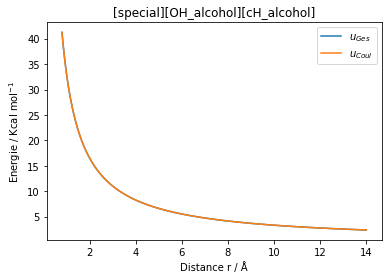

0.8
14.0


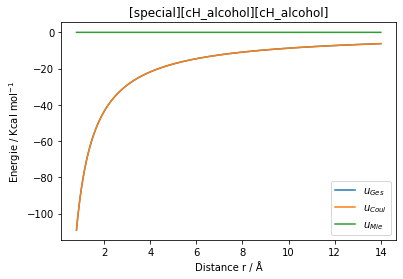

0.8
14.0


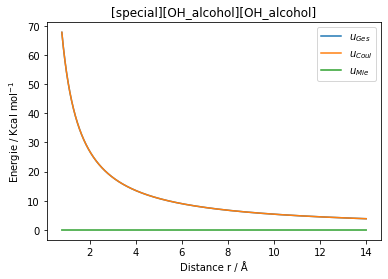

0.8
14.0


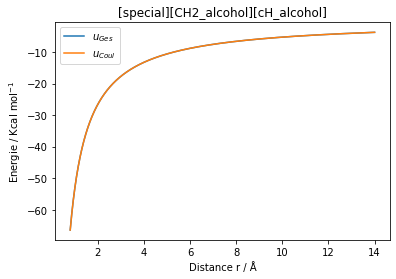

0.8
14.0


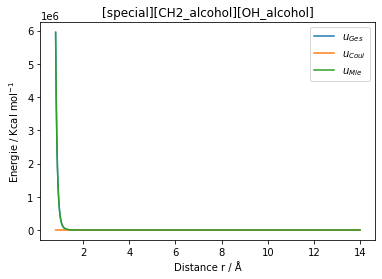

0.8
14.0


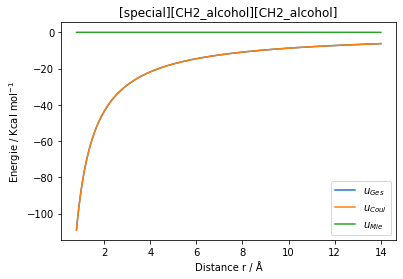

In [12]:
#Plot Energies

for key in plot_dict:
    r     = plot_dict[key]["r"]
    print(min(r))
    print(max(r))
    pot_g = plot_dict[key]["pot_ges"]
    pot_m = plot_dict[key]["pot_mie"]
    pot_c = plot_dict[key]["pot_coul"]
    pot_b = plot_dict[key]["pot_bond"]
    
    plt.plot(r,pot_g,label = "$u_{Ges}$")
    plt.plot(r,pot_c,label = "$u_{Coul}$")
    try:
        plt.plot(r,pot_m,label = "$u_{Mie}$")
    except:
        pass
    try:
        plt.plot(r,pot_b,label = "$u_{Bond}$") 
    except:
        pass
    
    plt.title(key)
    plt.legend()
    plt.xlabel("Distance r / Å")
    plt.ylabel("Energie / Kcal mol$^{-1}$")
    plt.show()
    plt.close()
    

In [13]:
with open("templates/template.bond_table") as file_:
    template = Template(file_.read())
rendered = template.render( rd=energy_list ) #Textformat wie in template
#print(rendered)

os.makedirs( "diols/" + species,exist_ok=True )
dummy = "diols/" + species + "/" + species + ".table"

with open(dummy, "w") as fh:
    fh.write(rendered) 